# Intro to Diffusion Models Workshop

*Created by Jack Douglas, UWaterloo Data Science Club*
<br>

**REMINDER: You can make a copy of this notebook by going to File > Save a copy in Drive**


---



## Summary

In this notebook, we will go over the use of diffusion models from the Hugging Face Diffusers and how to fine-tune a Stable Diffusion model. Documentation for the Diffusers library can be found here: https://huggingface.co/docs/diffusers/index.



## Packages/Libraries

Here we are using the Python package installer `pip` to install the `diffusers`, `accelerate`, and `transformers` libraries, all of which are created by Hugging Face.

In [1]:
!pip install --upgrade accelerate transformers datasets
!pip install git+https://github.com/huggingface/diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.6 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-wj1jri5d
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-wj1jri5d
  Resolved https://github.com/huggingface/diffusers to commit 51593da25

Here we are importing the Hugging Face notebook module so that we can use Hugging Face in this notebook. As well, we're importing the Stable Diffusion pipeline module and PyTorch.

In [2]:
from huggingface_hub import notebook_login
from diffusers import StableDiffusionPipeline
import torch

If you haven't already, you can make a Hugging Face account here: https://huggingface.co/join. As well, you will need to create a **write token** here: https://huggingface.co/settings/tokens. Paste the token below.

In [3]:
notebook_login()

# Out-of-the-box Usage

The StableDiffusionPipeline offers an API for making inferences with pre-trained models. In this case, we are specifying the Stable Diffusion version 1.1 which has model_id "CompVis/stable-diffusion-v1-1". You can find the model_id of other popular text-to-image diffusion models here: https://huggingface.co/models?pipeline_tag=text-to-image&sort=trending.


In [ ]:
PRETRAINED_MODEL_ID = "CompVis/stable-diffusion-v1-1" #@param ["CompVis/stable-diffusion-v1-1", "stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}
pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL_ID, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

unet/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

lora_id = "J-Douglas/pokemon-lora"
model = PeftModel.from_pretrained(pipe, lora_id)

Here we are prompting the model using the Stable Diffusion pipeline, and displaying the result.

  0%|          | 0/50 [00:00<?, ?it/s]

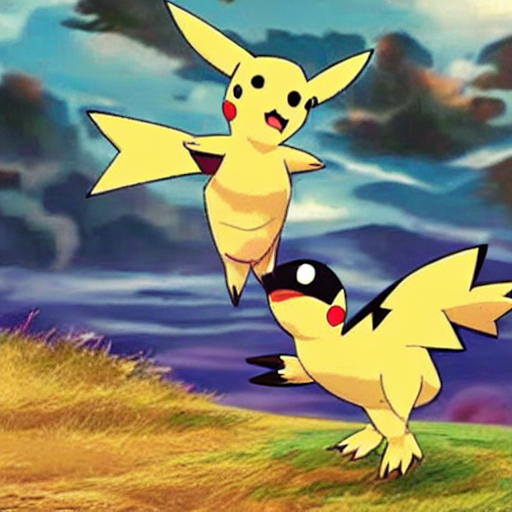

In [ ]:
prompt = "a pokemon goose radiating electricity"
image = model(prompt).images[0]
display(image)

## Fine-Tuning

We can improve the output of our Stable Diffusion model by fine-tuning it on a text-to-image dataset. For this notebook, we will be using the Pokémon Blip Captions dataset found here: https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions.

As well, this fine-tuning script was adapted from the text-to-image training script provided by Hugging Face here: https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py.

Here we are downloading the source distribution of diffusers which is needed for training scripts provided by Hugging Face. As well, we are installing the xformers library to help with memory efficiency. Finally, we are downloading the weights and biases library wandb to help with training.

In [ ]:
!pip install xformers
!pip install wandb

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-f0jgti3r
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-f0jgti3r
  Resolved https://github.com/huggingface/diffusers.git to commit aed7499a8d81de78bb1692d7a0745d3890618b0e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Setting up Hugging Face's Accelerate environment used for training models. You can read more about it here: https://huggingface.co/docs/accelerate/index.

In [ ]:
!python -c "from accelerate.utils import write_basic_config; write_basic_config(mixed_precision='fp16')"
!accelerate env

2023-07-05 20:24:42.695328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Configuration already exists at /root/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.
2023-07-05 20:24:59.510279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

Copy-and-paste the text below in your GitHub issue

- `Accelerate` version: 0.20.3
- Platform: Linux-5.15.107+-x86_64-with-glibc2.31
- Python version: 3.10.12
- Numpy version: 1.22.4
- PyTorch version (GPU?): 2.0.1+cu118 (True)
- PyTorch XPU available: False
- System RAM: 12.68 GB
- GPU type: Tesla T4
- `Accelerate` default config:
	- compute_environment: LOCAL_MACHINE
	- distributed_type: NO
	- mixed_precision: fp16
	- use_cpu: False
	- num_processes: 1
	- machine_rank: 0
	- num_machines: 1
	- rdzv_backend: static
	- same_network: False
	- main_training_function: ma

Downloading text-to-image LoRA training script for here: https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py.

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py

--2023-07-05 20:25:02--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41058 (40K) [text/plain]
Saving to: ‘train_text_to_image_lora.py.1’

train_text_to_image 100%[===================>]  40.10K  --.-KB/s    in 0.004s  

2023-07-05 20:25:02 (9.19 MB/s) - ‘train_text_to_image_lora.py.1’ saved [41058/41058]



### Image-Caption Dataset

Here is the name of our image-caption dataset that we are using to fine-tune the model. We are using the Pokémon Blip Captions dataset found here: https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions. You can find more image-caption datasets here: https://huggingface.co/datasets?task_categories=task_categories:text-to-image&sort=trending.

In [ ]:
DATASET_NAME="lambdalabs/pokemon-blip-captions"

### Parameters

Here we are specifying parameters for our training script. Feel free to adjust the

In [ ]:
TRAINING_STEPS = 100 # Make this larger
LEARNING_RATE = 1e-04
BATCH_SIZE = 1
RESOLUTION = 512
GRADIENT_ACCUMULATION_STEPS = 4
REPO_ID="pokemon-lora"

In [ ]:
!/usr/bin/python3 train_text_to_image_lora.py  \
  --pretrained_model_name_or_path={PRETRAINED_MODEL_ID} \
  --dataset_name={DATASET_NAME} \
  --dataloader_num_workers=8 \
  --resolution={RESOLUTION} --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps={TRAINING_STEPS} \
  --learning_rate={LEARNING_RATE} \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir={REPO_ID} \
  --push_to_hub \
  --hub_model_id={REPO_ID} \
  --report_to=wandb \
  --checkpointing_steps=500 \
  --validation_prompt="pokemon goose" \
  --seed=1337 \
  --mixed_precision="fp16" \
  --enable_xformers_memory_efficient_attention

2023-07-05 20:25:12.222487: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
07/05/2023 20:25:21 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'dynamic_thresholding_ratio', 'clip_sample_range', 'variance_type', 'clip_sample', 'timestep_spacing', 'prediction_type', 'thresholding', 'sample_max_value'} was not found in config. Values will be initialized to default values.
{'norm_num_groups', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'addition_embed_type', 'time_embedding_dim', 'dual_cross_attention', 'encoder_hid_dim', 'num_attention_heads', 'timestep_post_act', 'mid_block_type', 'upcast_attention', 'time_cond_proj_dim', 'only_cross_attention', 'resnet_time_scale_shift', 'encoder_hid_dim_type', 'resnet_out_scale_factor', 'addition_embed_type_num_heads', 'mid_block_only_cross_attention', 'conv_ou

text_encoder/model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

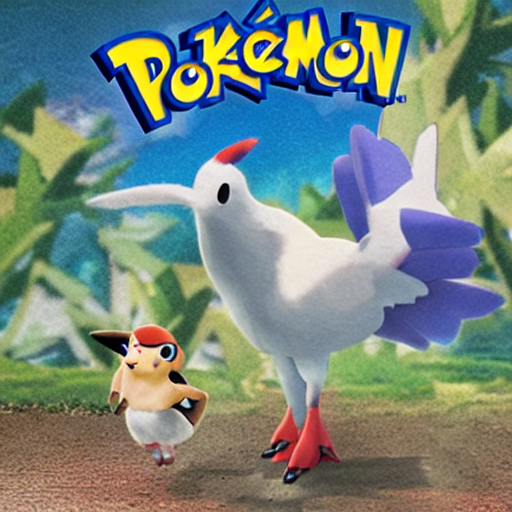

In [ ]:
from diffusers import DPMSolverMultistepScheduler

pipe = StableDiffusionPipeline.from_pretrained(PRETRAINED_MODEL_ID, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.unet.load_attn_procs(REPO_ID)
pipe.to("cuda")

prompt = "pokemon goose"
image = pipe(prompt, num_inference_steps=25).images[0]
display(image)